# Training a Neural Network Splitting the Data


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch02_DNN_regression/ec02_5_dnn2_reg_split/dnn2_reg_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to copy the auxiliary *.csv and *.py files from the
<a href="https://github.com/DeepTrackAI/DeepLearningCrashCourse/tree/main/Ch02_DNN_regression/ec02_5_dnn2_reg_split">notebook folder</a>
in GitHub to the Colab/Kaggle work directory.
</div>

This notebook provides you with a complete code example that loads the data contained in the `data_reg_2d_nonlinear.csv` file and splits them into a training, a validation, and a test set. Then, it trains a two-layer neural network using the training data, while monitoring the training and validation MSE. Finally, it uses the trained network to predict the values of the test data (test hold-out dataset) in the `data_reg_2d_linear_test.csv` file.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 2-5 from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading and Splitting the Data

In [1]:
from loader import load_data

(x, y_gt) = load_data(filename="data_reg_2d_nonlinear.csv")

In [2]:
from numpy import delete, split
from numpy.random import choice

num_samples = len(x)
split = .70

num_samples_train = int(split * num_samples)
train_idx = choice(num_samples, num_samples_train, replace=False)

x_train = x[train_idx]  # Train inputs
y_gt_train = y_gt[train_idx]  # Train ground truths

x_val = delete(x, train_idx, axis=0)  # Validation inputs
y_gt_val = delete(y_gt, train_idx, axis=0)  # Validation ground truths

## Implementing a Dense Neural Network

Implement the sigmoidal function ...

In [3]:
from numpy import exp

def sigmoid(x):
    """Sigmoid function."""
    return 1 / (1 + exp(-x))

... implement a function to define the neural network ...

In [4]:
def dnn2_reg(wa, wb, x):
    """Two-layer dense neural network for classification."""
    return sigmoid(x @ wa) @ wb

... define the number of neurons of the first layer ...

In [5]:
num_neurons = 10

... randomly initialize its weights ...

In [6]:
from numpy.random import default_rng

rng = default_rng()
wa = rng.standard_normal(size=(2, num_neurons))  # Input weights layer 1
wb = rng.standard_normal(size=(num_neurons, 1))  # Input weights layer 2

... obtain its predictions for the training and validation datasets ...

In [7]:
y_p_train = dnn2_reg(wa, wb, x_train)
y_p_val = dnn2_reg(wa, wb, x_val)

... and plot its predictions for the training dataset ...

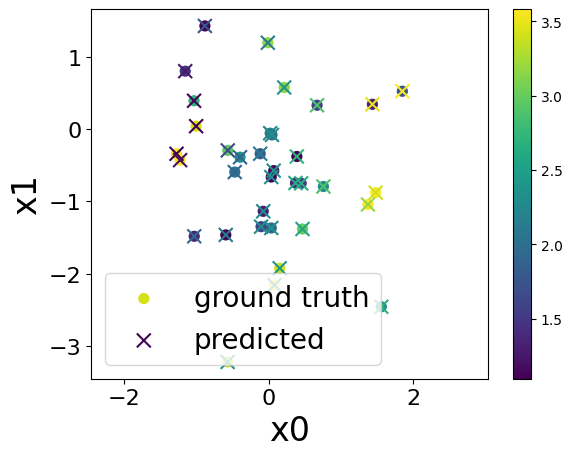

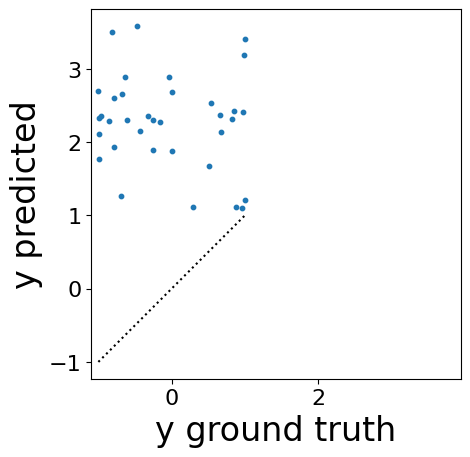

In [8]:
from plotting import plot_pred_2d, plot_pred_vs_gt

plot_pred_2d(x_train, y_gt_train, y_p=dnn2_reg(wa, wb, x_train))
plot_pred_vs_gt(y_gt_train, y_p=dnn2_reg(wa, wb, x_train))

... and for the validation dataset.

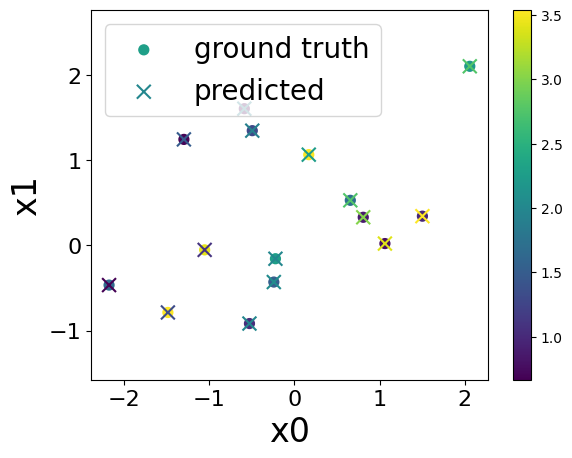

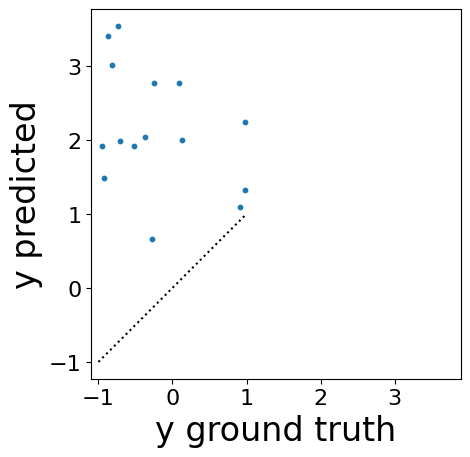

In [9]:
plot_pred_2d(x_val, y_gt_val, y_p=dnn2_reg(wa, wb, x_val))
plot_pred_vs_gt(y_gt_val, y_p=dnn2_reg(wa, wb, x_val))

## Training and Validating the Neural Network

Implement the first derivative of the sigmoid function ...

In [10]:
def d_sigmoid(x):
    """Derivative of sigmoid function."""
    return sigmoid(x) * (1 - sigmoid(x))

... implement the backpropagation algorithm with mini-batches ...

In [ ]:
from numpy import mean, reshape, sum, transpose, zeros
from numpy.random import permutation

num_samples_train = len(x_train)
num_batches = 7
batch_size = int(num_samples_train / num_batches)
num_epochs = 10 ** 4
eta = .1  # Learning rate

mse_train, mse_val = zeros((num_epochs,)), zeros((num_epochs,))
for epoch in range(num_epochs):
    # Permute samples.
    permuted_order_samples = permutation(num_samples_train)
    x_permuted = x_train[permuted_order_samples]
    y_gt_permuted = y_gt_train[permuted_order_samples]

    for batch_start in range(0, num_samples_train, batch_size):
        dwa = zeros(wa.shape)  # Initialize weight increments layer 1
        dwb = zeros(wb.shape)  # Initialize weight increments layer 2
        for selected in range(batch_start, batch_start + batch_size):
            x_selected = reshape(x_permuted[selected], (1, -1))
            y_gt_selected = reshape(y_gt_permuted[selected], (1, -1))

            # Detailed neural network calculation.
            x_selected_a = x_selected  # Input layer 1
            p_a = x_selected_a @ wa  # Activation potential layer 1
            y_selected_a = sigmoid(p_a)  # Output layer 1

            x_selected_b = y_selected_a  # Input layer 2
            p_b = x_selected_b @ wb  # Activation potential layer 2
            y_selected_b = p_b  # Output layer 2 (output neuron)
        
            y_p_selected = y_selected_b
        
            # Update weight increments.
            error = y_p_selected - y_gt_selected

            delta_b = error * 1
            dwb = dwb - eta * delta_b * transpose(x_selected_b)

            delta_a = sum(wb * delta_b, axis=1) * d_sigmoid(p_a)
            dwa = dwa - eta * delta_a * transpose(x_selected_a)

        wa = wa + dwa / batch_size  # Update weights layer 1
        wb = wb + dwb / batch_size  # Update weights layer 2

    y_p_train = dnn2_reg(wa, wb, x_train)
    mse_train[epoch] = mean((y_p_train - y_gt_train) ** 2)

    y_p_val = dnn2_reg(wa, wb, x_val)
    mse_val[epoch] = mean((y_p_val - y_gt_val) ** 2)

    print(f"epoch={epoch} MSE train={mse_train[epoch]:.4f} val={mse_val[epoch]:.4f}")

epoch=0 MSE train=0.8132 val=1.2810
epoch=1 MSE train=0.6679 val=0.8479
epoch=2 MSE train=0.6244 val=0.7712
epoch=3 MSE train=0.5905 val=0.6734
epoch=4 MSE train=0.5662 val=0.6019
epoch=5 MSE train=0.5486 val=0.5553
epoch=6 MSE train=0.5355 val=0.5245
epoch=7 MSE train=0.5290 val=0.4867
epoch=8 MSE train=0.5243 val=0.4948
epoch=9 MSE train=0.5120 val=0.4665
epoch=10 MSE train=0.5144 val=0.4442
epoch=11 MSE train=0.5016 val=0.4513
epoch=12 MSE train=0.4959 val=0.4358
epoch=13 MSE train=0.4983 val=0.4445
epoch=14 MSE train=0.4887 val=0.4230
epoch=15 MSE train=0.4872 val=0.4250
epoch=16 MSE train=0.4889 val=0.4082
epoch=17 MSE train=0.4800 val=0.4113
epoch=18 MSE train=0.4774 val=0.4058
epoch=19 MSE train=0.4756 val=0.4099
epoch=20 MSE train=0.4748 val=0.3963
epoch=21 MSE train=0.4786 val=0.3916
epoch=22 MSE train=0.4672 val=0.3931
epoch=23 MSE train=0.4859 val=0.3876
epoch=24 MSE train=0.4627 val=0.3917
epoch=25 MSE train=0.4622 val=0.3805
epoch=26 MSE train=0.4571 val=0.3826
epoch=27 MS

... and plot the training metrics (which often feature overfitting) ...

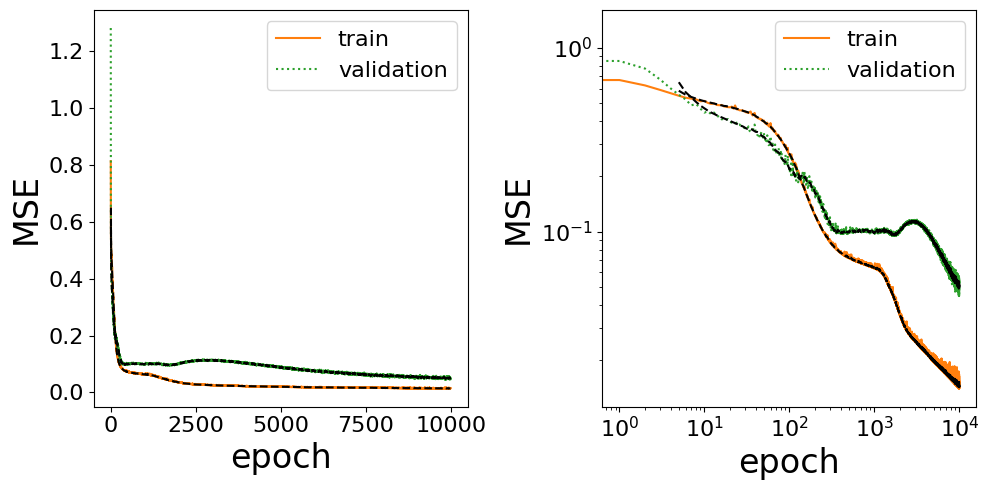

In [12]:
from plotting import plot_mse_train_vs_val

plot_mse_train_vs_val(mse_train, mse_val)

... and the predictions for the training set ...

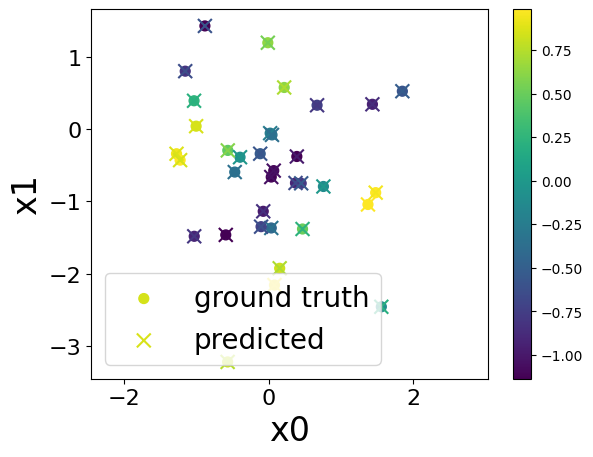

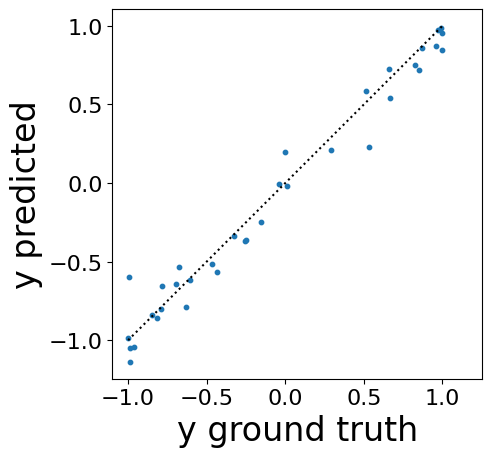

In [13]:
plot_pred_2d(x_train, y_gt_train, y_p=dnn2_reg(wa, wb, x_train))
plot_pred_vs_gt(y_gt_train, y_p=dnn2_reg(wa, wb, x_train))

... the predictions for the validation set ...

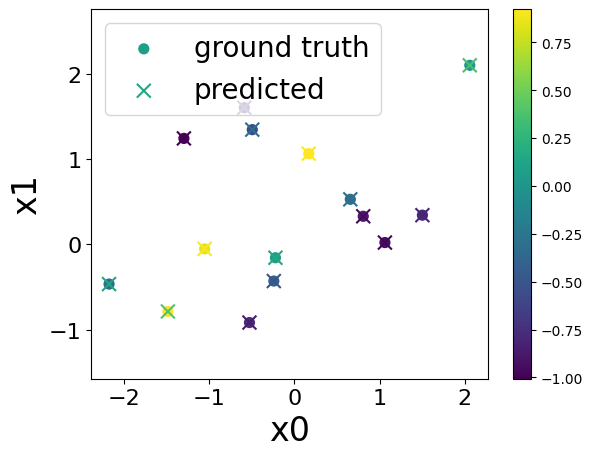

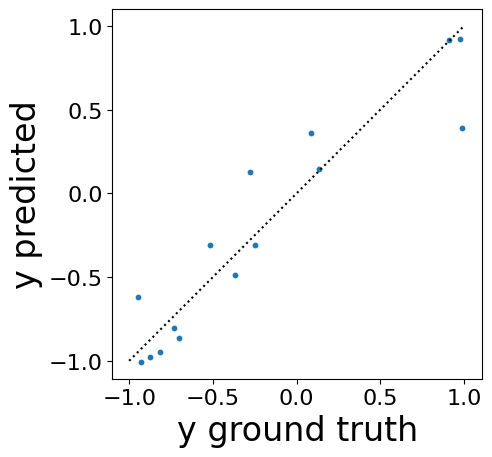

In [14]:
plot_pred_2d(x_val, y_gt_val, y_p=dnn2_reg(wa, wb, x_val))
plot_pred_vs_gt(y_gt_val, y_p=dnn2_reg(wa, wb, x_val))

... and the predictions for the test set.

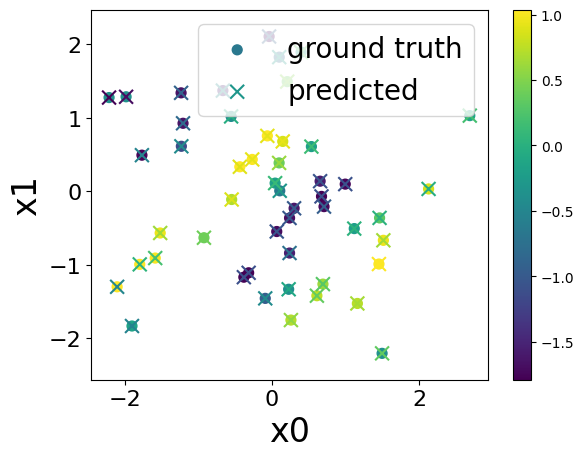

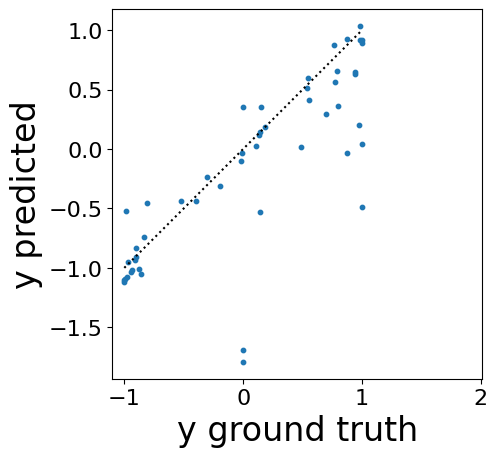

In [15]:
(x_test, y_gt_test) = load_data(filename="data_reg_2d_nonlinear_test.csv")

plot_pred_2d(x_test, y_gt_test, y_p=dnn2_reg(wa, wb, x_test))
plot_pred_vs_gt(y_gt_test, y_p=dnn2_reg(wa, wb, x_test))